
=== Analyzing EU_N_train_512_N_valid_4096_losses.npz ===


Mean real_loss = 1.506316
Mean topk_min_loss = 0.099154


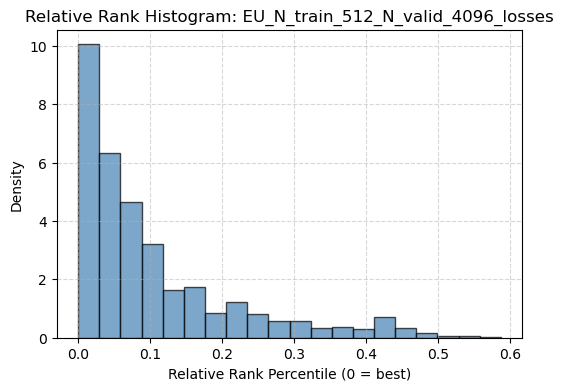

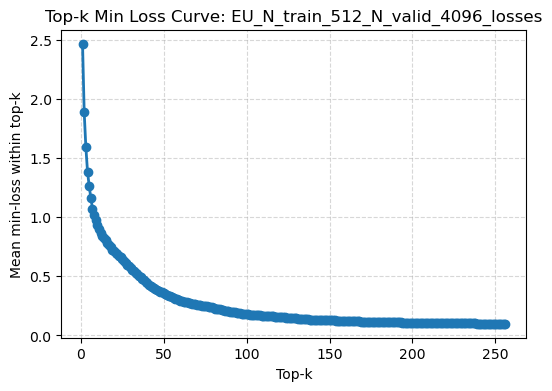

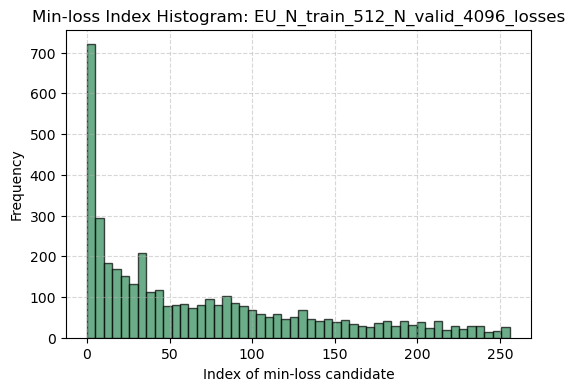

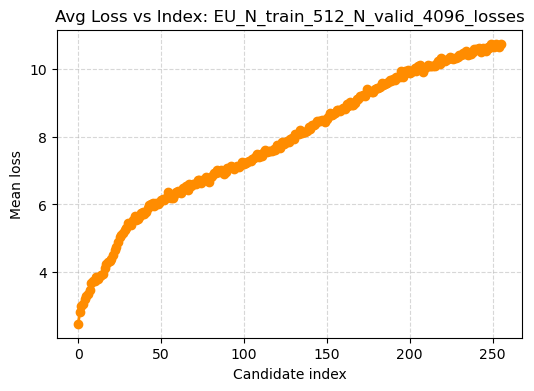

Spearman correlation (index vs. loss): 0.4462 (p=0.00e+00)

=== Analyzing EU_N_train_1024_N_valid_4096_losses.npz ===
Mean real_loss = 1.506316
Mean topk_min_loss = 0.093338


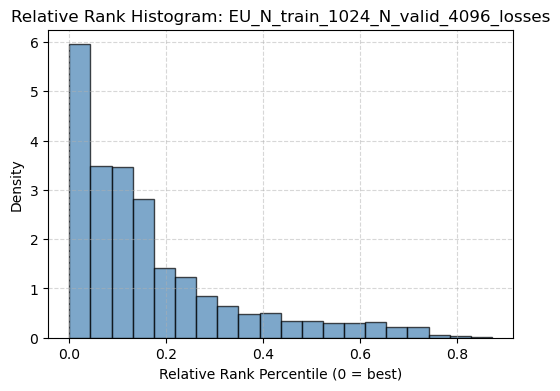

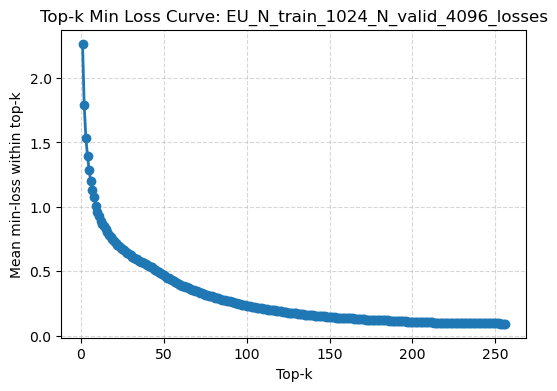

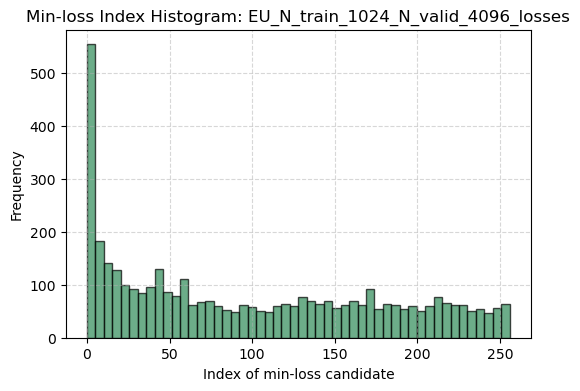

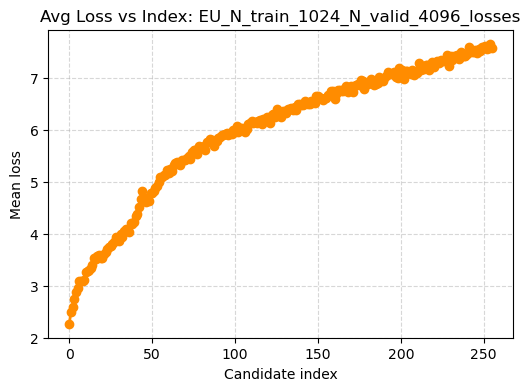

Spearman correlation (index vs. loss): 0.2836 (p=0.00e+00)

=== Analyzing EU_N_train_2048_N_valid_4096_losses.npz ===
Mean real_loss = 1.506316
Mean topk_min_loss = 0.119045


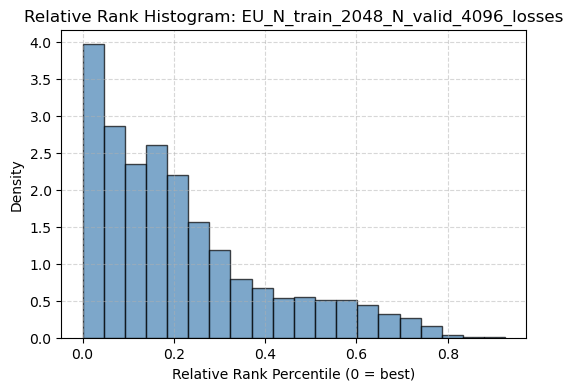

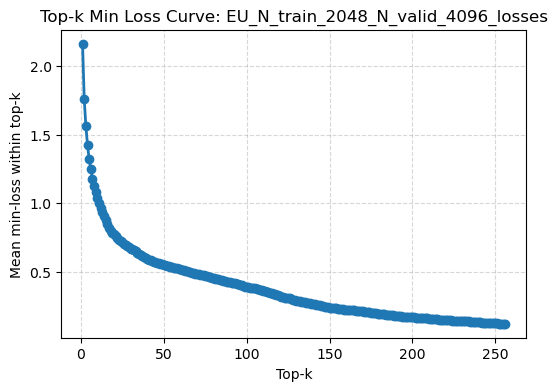

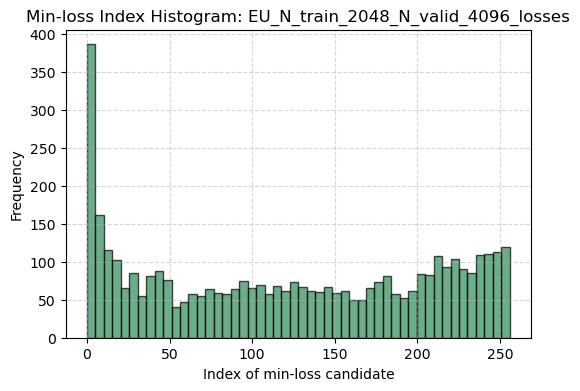

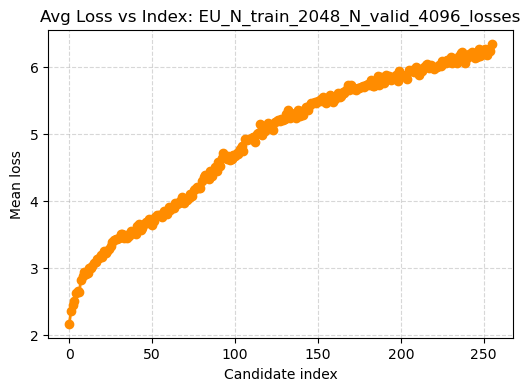

Spearman correlation (index vs. loss): 0.2479 (p=0.00e+00)

=== Analyzing EU_N_train_4096_N_valid_4096_losses.npz ===
Mean real_loss = 1.506316
Mean topk_min_loss = 0.204181


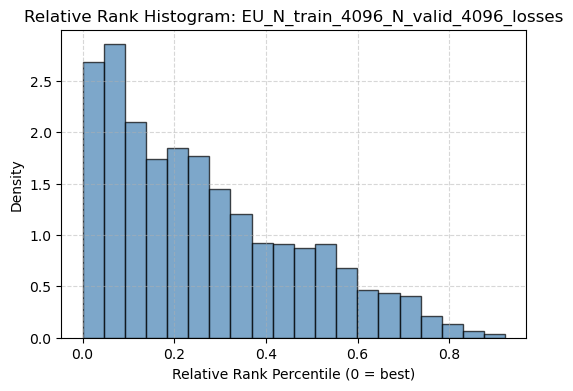

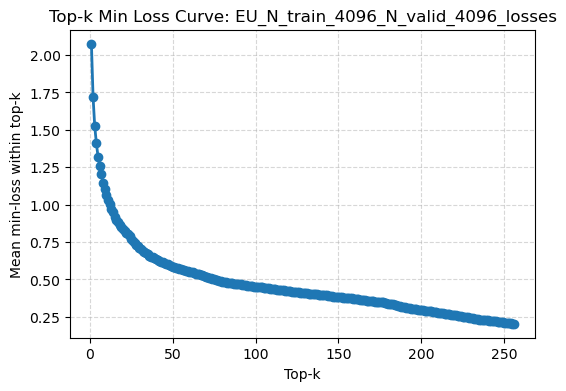

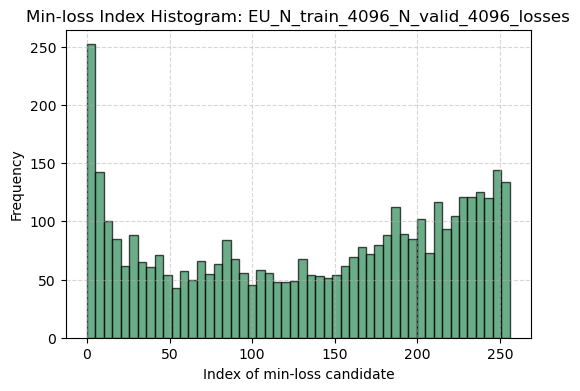

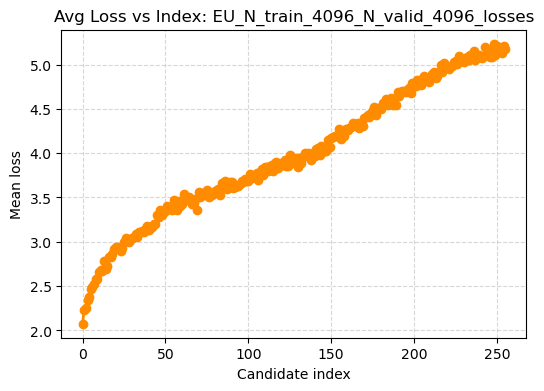

Spearman correlation (index vs. loss): 0.1976 (p=0.00e+00)

=== Analyzing EU_Ntrain_8192_N_valid_4096_losses.npz ===


FileNotFoundError: [Errno 2] No such file or directory: 'EU_Ntrain_8192_N_valid_4096_losses.npz'

In [3]:
# analysis.ipynb

### ========== 1. 导入依赖 ==========
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict


### ========== 2. 数据读取接口 ==========
def load_data(file_path: str):
    data = np.load(file_path)
    real_losses = data["real_losses"]
    topk_losses = data["topk_losses"]
    real_label = data["real_label"]
    topk_label = data["topk_label"]
    ground_truth_label = data["ground_truth_label"]
    return real_losses, topk_losses, real_label, topk_label, ground_truth_label


### ========== 3. 排名计算接口 ==========
def compute_relative_ranks(real_losses: np.ndarray, topk_losses: np.ndarray) -> np.ndarray:
    """
    向量化计算 real_losses 在 {real_loss + topk_losses} 内的相对排名百分位.
    0 = 最优，1 = 最差。
    """
    N, K = topk_losses.shape
    # 拼接 real_losses
    all_losses = np.concatenate(
        [real_losses[:, None], topk_losses], axis=1
    )  # (N, K+1)

    # 对每一行排序，返回排序后的索引
    order = np.argsort(all_losses, axis=1)  # (N, K+1)

    # 找到 real_loss 在排序中的位置（real_loss 在拼接数组的第 0 列）
    real_positions = np.argwhere(order == 0)[:, 1]  # (N,)

    # 归一化到 [0,1]
    relative_ranks = real_positions / (K + 1)

    return relative_ranks



### ========== 4. 绘图接口 ==========
def plot_rank_histogram(relative_ranks: np.ndarray, title: str, bins: int = 20):
    """
    绘制相对排名的直方图.
    """
    plt.figure(figsize=(6,4))
    plt.hist(relative_ranks, bins=bins, density=True, alpha=0.7, color="steelblue", edgecolor="black")
    plt.xlabel("Relative Rank Percentile (0 = best)")
    plt.ylabel("Density")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
def plot_topk_min_curve(topk_losses: np.ndarray, title: str):
    """
    绘制 top-k 最优曲线:
    横轴: k (1 ~ K)
    纵轴: 对每个样本, 取前 k 个候选的最小 loss, 再对所有样本取均值
    """
    N, K = topk_losses.shape
    # 计算累积最小值 (沿候选维度逐步取 min)
    cum_min = np.minimum.accumulate(topk_losses, axis=1)  # (N, K)
    # 对样本取均值
    avg_cum_min = cum_min.mean(axis=0)  # (K,)

    # 绘图
    plt.figure(figsize=(6,4))
    plt.plot(range(1, K+1), avg_cum_min, marker="o", linewidth=2)
    plt.xlabel("Top-k")
    plt.ylabel("Mean min-loss within top-k")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
def plot_min_index_histogram(topk_losses: np.ndarray, title: str, bins: int = None):
    """
    绘制最优候选所在 index 的直方图.
    横轴: 候选 index (0 ~ K-1)
    纵轴: 出现频率
    """
    N, K = topk_losses.shape
    # 每个样本中 min-loss 的 index
    min_indices = np.argmin(topk_losses, axis=1)

    # 默认 bin = K
    if bins is None:
        bins = K

    plt.figure(figsize=(6,4))
    plt.hist(min_indices, bins=bins, range=(0, K), color="seagreen", alpha=0.7, edgecolor="black")
    plt.xlabel("Index of min-loss candidate")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
from scipy.stats import spearmanr

def plot_avg_loss_vs_index(topk_losses: np.ndarray, title: str):
    """
    绘制平均 loss vs. index 曲线，并输出 Spearman 相关系数.
    横轴: 候选 index
    纵轴: 平均 loss
    """
    N, K = topk_losses.shape

    # (1) 计算平均 loss
    mean_losses = topk_losses.mean(axis=0)  # (K,)

    # (2) 绘图
    plt.figure(figsize=(6,4))
    plt.plot(range(K), mean_losses, marker="o", linewidth=2, color="darkorange")
    plt.xlabel("Candidate index")
    plt.ylabel("Mean loss")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # (3) 相关系数 (flatten 后计算)
    indices = np.tile(np.arange(K), N)          # (N*K,)
    losses  = topk_losses.reshape(-1)           # (N*K,)
    rho, pval = spearmanr(indices, losses)

    print(f"Spearman correlation (index vs. loss): {rho:.4f} (p={pval:.2e})")

    return rho, pval


### ========== 5. 批量处理入口 ==========
def analyze_files(file_list: List[str]):
    """
    读取多组数据，输出均值信息，并绘制排名直方图.
    """
    for file_path in file_list:
        print(f"\n=== Analyzing {file_path} ===")
        real_losses, topk_losses, real_label, topk_label, ground_truth_label = load_data(file_path)

        # 计算指标
        relative_ranks = compute_relative_ranks(real_losses, topk_losses)
        real_mean = real_losses.mean()
        topk_min_mean = topk_losses.min(axis=1).mean()

        print(f"Mean real_loss = {real_mean:.6f}")
        print(f"Mean topk_min_loss = {topk_min_mean:.6f}")

        # 绘图
        plot_rank_histogram(relative_ranks, title=f"Relative Rank Histogram: {Path(file_path).stem}")
        plot_topk_min_curve(topk_losses, title=f"Top-k Min Loss Curve: {Path(file_path).stem}")
        plot_min_index_histogram(topk_losses, title=f"Min-loss Index Histogram: {Path(file_path).stem}", bins=50)
        plot_avg_loss_vs_index(topk_losses, title=f"Avg Loss vs Index: {Path(file_path).stem}")


### ========== 6. 示例调用 ==========
# 在实际运行中，把下面改成你的文件名列表
if __name__ == "__main__":
    file_list = [
        "EU_N_train_512_N_valid_4096_losses.npz",
        "EU_N_train_1024_N_valid_4096_losses.npz",
        "EU_N_train_2048_N_valid_4096_losses.npz",
        "EU_N_train_4096_N_valid_4096_losses.npz",
        "EU_Ntrain_8192_N_valid_4096_losses.npz",
        "EU_N_train_16384_N_valid_4096_losses.npz",
        "EU_N_train_32768_N_valid_4096_losses.npz",
    ]
    analyze_files(file_list)# 在 analyze_files 内部
    

